# Práctica 2 - MLP para funciones lógicas - Lab 2
## Preparación de entorno
#### Instalar las librerías

In [406]:
#%pip install torch torchvision pandas matplotlib

#### Importar librerías de código

In [407]:
import torch # type: ignore
import torch.nn as nn # type: ignore
import torch.optim as optim # type: ignore
from sklearn.metrics import f1_score # type: ignore
from sklearn.preprocessing import StandardScaler, MinMaxScaler # type: ignore
import pandas as pd # type: ignore
import random
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
from torch.utils.data import DataLoader, TensorDataset, random_split # type: ignore

### Preparación de los datos de entrenamiento


En primer lugar, importaremos nuestro dataset con pandas, con el fin de crear un dataframe que nos permita trabajar con los datos de forma más cómoda.

In [408]:
df_train = pd.read_csv("data/got_train.csv")

Una vez tenemos el dataset con las columnas necesarias, dividiremos los datos entre las carácterísticas de entrenamiento y el atributo objetivo, que en este caso es *alive*.

In [409]:
# Características del entrenamiento
x_train = df_train[['male', 'isMarried', 'isNoble', 'numDeadRelations', 'isPopular', 'book1', 'book2', 'book3', 'book4', 'book5']]
# Objetivo
y_train = df_train['alive']
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)


Antes de pasar con la definición del modelo, debemos convertir nuestros datos a tensores, de tal manera que podamos trabajar con ellos en PyTorch.  
En el caso del target, al ser un dataset unidimensional, debemos transformarlo a una matriz de una columna y n filas para que sea compatible con las funciones de pérdida y del modelo que usaremos posteriormente.

In [410]:
x_train_tensor = torch.tensor(x_train_scaled, dtype= torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype= torch.float32).view(-1, 1)

## MLP SetUp

Una vez hemos preparado nuestros datos de entrenamiento, procederemos con la definición de nuestro modelo. Para ello, empezaremos definiendo los hiperparámetros.

In [411]:
input_size = x_train_tensor.shape[1] # Número de características de entrada que va a usar el modelo.
hidden_size = 32 # Número de neuronas de la capa oculta
output_size = 1 # Número de nueronas de salida. Ponemos 1 porque va a ser una clasificación binaria (vivo/muerto)

batch_size = 64
learning_rate = 0.001
num_epochs = 100
validation_split = 0.2 

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Con los hiperparámetros definidos, podemos crear nuestro modelo MLP.

In [412]:
class RedNeuronalGot(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RedNeuronalGot, self).__init__()
        # Capas de la red
        self.capa1 = nn.Linear(input_size, hidden_size)
        self.capa2 = nn.Linear(hidden_size, hidden_size*2)
        self.capa3 = nn.Linear(hidden_size*2, hidden_size)
        self.capa4 = nn.Linear(hidden_size, output_size)

        #Función de activación
        self.relu = nn.ReLU()
        #Función de activación para la capa de salida (binaria)
        self.sigmoid = nn.Sigmoid()
        # Establecemos un dropout para evitar que no hayan neuronas que acaben siendo insignificantes
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.relu(self.capa1(x))
        x = self.dropout(x)
        x = self.relu(self.capa2(x))
        x = self.dropout(x)
        x = self.relu(self.capa3(x))
        x = self.dropout(x)
        x = self.capa4(x)
        x = self.sigmoid(x)  # Aplicamos Sigmoid para obtener un valor entre 0 y 1
        return x

En este caso, hemos decidido utilizar la función de activación Relu para las capas intermedias, y para la capa de salida, la sigmoidea, ya que nos va a sacar siempre un valor entre 0 y 1, que es lo que nos interesa a nosotros para nuestra predicción.  

A continuación, dividiremos los datos de entrenamiento y los de validación.

In [413]:
dataset = TensorDataset(x_train_tensor, y_train_tensor)
dataset_size = len(x_train_tensor)
validation_size = int(validation_split * dataset_size)
train_size = dataset_size - validation_size

train_dataset, val_dataset = random_split(dataset, [train_size, validation_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Ya con el dataset dividido y adaptado a a PyTorch, podemos proceder instanciando el modelo y definiendo su función de pérdida y optimizador. En este caso, al tratarse de un problema de predicción entre 0 y 1, la función de pérdida más adecuada es **Binary Cross-Entropy Loss**, ya que tiene una menor penalización para los errores más pequeños y tiene un enfoque más probabilístico, que es lo que estamos buscando. [Fuente](https://medium.com/@hatodi0945/a-comparison-between-mse-cross-entropy-and-hinge-loss-4d4fe63cca12#:~:text=The%20MSE%20loss%20is%20therefore,several%20iterations%20of%20model%20training.)

In [414]:
model = RedNeuronalGot(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## MLP Entrenamiento básico

Con los últimos parámetros establecidos, podemos proceder con las funciones previas al entrenamiento. En primer lugar, definiremos la función de evaluación, que medirá el rendimiento de nuestro modelo durante el entrenamiento.

In [415]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    total_mse = 0
    
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            mse = torch.mean((outputs - batch_y)**2)
            
            total_loss += loss.item()
            total_mse += mse.item()
    
    avg_loss = total_loss / len(dataloader)
    avg_mse = total_mse / len(dataloader)
    
    return avg_loss, avg_mse

Antes de empezar a entrenar el modelo, definiremos algunas variables que nos permitirán almacenar información importante relativa al entrenamiento.

In [416]:
best_val_loss = float('inf')
best_train_loss = float('inf')
best_val_mse = float('inf')
best_model_state = None

train_losses = []
val_losses = []
val_mses = []

umbral_early_stop = 15
contador_early_stop = 0

Ya con todo listo, procederemos a entrenar nuestra red neuronal.

In [417]:

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_mse = 0
    
    for batch_x, batch_y in train_loader:
        # Forward
        outputs = model(batch_x.float())
        loss = criterion(outputs, batch_y.float())
        mse = torch.mean((outputs - batch_y)**2)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_mse += mse.item()
    
    # Pérdida de entrenamiento
    avg_train_loss = train_loss / len(train_loader)
    avg_train_mse = train_mse / len(train_loader)
    train_losses.append(avg_train_loss)
    
    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss

    # Validación
    model.eval()
    val_loss = 0
    val_mse = 0
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            outputs = model(batch_x.float())
            loss = criterion(outputs, batch_y.float())
            mse = torch.mean((outputs - batch_y)**2)
            
            val_loss += loss.item()
            val_mse += mse.item()
    
    avg_val_loss = val_loss / len(val_loader)
    avg_val_mse = val_mse / len(val_loader)
    
    val_losses.append(avg_val_loss)
    val_mses.append(avg_val_mse)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        contador_early_stop = 0  # Si hay mejora, el contador vuelve a 0
    else:
        contador_early_stop += 1  # Si no mejora, se suma 1 al contador

    if contador_early_stop >= umbral_early_stop:
        print(f'\nParando entrenamiento en la época {epoch+1} por Early Stopping.')
        break
    
    if avg_val_mse < best_val_mse:
        best_val_mse = avg_val_mse
    
    if (epoch + 1) % 10 == 0:
        print(f'Época [{epoch+1}/{num_epochs}]')
        print(f'Pérdida de entrenamiento: {avg_train_loss:.4f}')
        print(f'Pérdida de validación: {avg_val_loss:.4f}')
        print(f'MSE de entrenamiento: {avg_train_mse:.4f}')
        print(f'MSE de validación: {avg_val_mse:.4f}')
        print('-' * 50)

model.load_state_dict(best_model_state)

print(f'Mejor pérdida de entrenamiento: {best_train_loss:.4f}')
print(f'Mejor pérdida de validación: {best_val_loss:.4f}')
print(f'Mejor MSE de validación: {best_val_mse:.4f}')

Época [10/100]
Pérdida de entrenamiento: 0.0690
Pérdida de validación: 0.0679
MSE de entrenamiento: 0.0690
MSE de validación: 0.0679
--------------------------------------------------
Época [20/100]
Pérdida de entrenamiento: 0.0638
Pérdida de validación: 0.0672
MSE de entrenamiento: 0.0638
MSE de validación: 0.0672
--------------------------------------------------
Época [30/100]
Pérdida de entrenamiento: 0.0626
Pérdida de validación: 0.0664
MSE de entrenamiento: 0.0626
MSE de validación: 0.0664
--------------------------------------------------
Época [40/100]
Pérdida de entrenamiento: 0.0595
Pérdida de validación: 0.0654
MSE de entrenamiento: 0.0595
MSE de validación: 0.0654
--------------------------------------------------
Época [50/100]
Pérdida de entrenamiento: 0.0592
Pérdida de validación: 0.0659
MSE de entrenamiento: 0.0592
MSE de validación: 0.0659
--------------------------------------------------
Época [60/100]
Pérdida de entrenamiento: 0.0606
Pérdida de validación: 0.0647
MS

Una vez hemos entrenado la red, podemos realizar una gráfica nos muestre como ha ido evolucionando la pérdida a lo largo del entrenamiento. Esto nos permitirá determinar si nuestra red ha aprendido correctamente, observar si necesita más epochs o si necesitamos cambiar algún hiperparámetro.

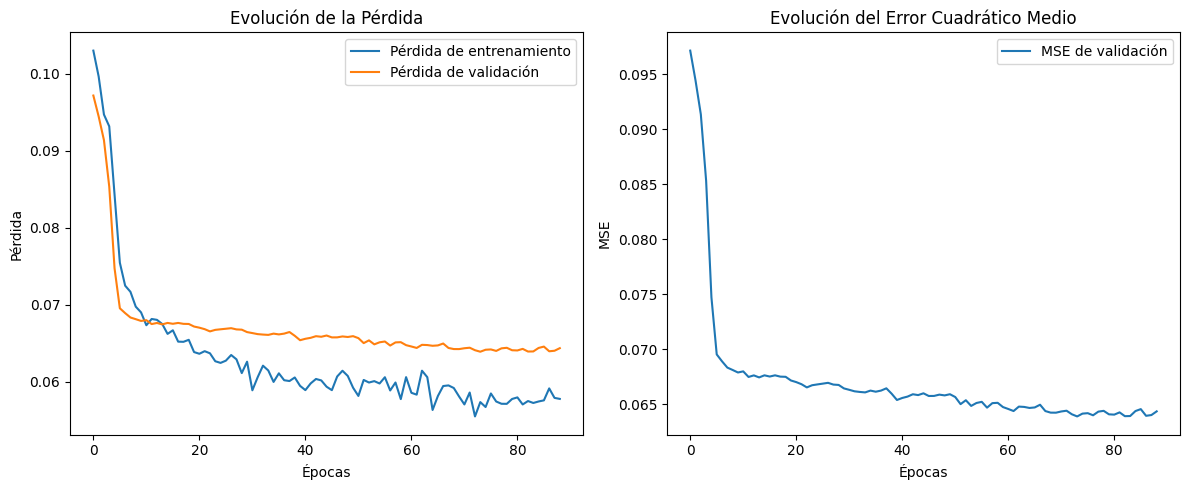

In [418]:
# Gráficas
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label='Pérdida de entrenamiento')
plt.plot(range(len(val_losses)), val_losses, label='Pérdida de validación')
plt.title('Evolución de la Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(val_mses)), val_mses, label='MSE de validación')
plt.title('Evolución del Error Cuadrático Medio')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

## MLP Evaluación final

Con el modelo correctamente entrenado, procederemos a realizar algunas pruebas para evaluar la capacidad de predicción de nuestro modelo. Para ello, usaremos el dataset *got_predict.csv*, buscando que personaje tiene más probabilidades de morir.  

Para ello, en primer lugar convertiremos el csv a dataframe igual que hicimos con los datos de entrenamiento, para posteriormente aplicar el mismo preprocesamiento que utilizamos con los datos anteriores.

In [419]:
df_predict = pd.read_csv("data/got_predict.csv")

nombres_personajes = df_predict['name']

x_predict = df_predict[['male', 'isMarried', 'isNoble', 'numDeadRelations', 'isPopular', 'book1', 'book2', 'book3', 'book4', 'book5']]
x_predict_scaled = scaler.transform(x_predict)

x_predict_tensor = torch.tensor(x_predict_scaled, dtype=torch.float32)

Ya con los datos preprocesados, podemos utilizar nuestro modelo para la predicción.

In [420]:
model.eval()
with torch.no_grad():
    predicciones = model(x_predict_tensor).numpy().flatten()


resultados = pd.DataFrame({'Personaje': nombres_personajes, 'Probabilidad_Morir': predicciones})

resultados = resultados.sort_values(by='Probabilidad_Morir', ascending=False)

print(resultados.head(7))

                       Personaje  Probabilidad_Morir
2                      Coldhands            0.710090
3                 Othell Yarwyck            0.554014
4  Roland Crakehall (Kingsguard)            0.456576
1             Daenerys Targaryen            0.100902
0               Tommen Baratheon            0.015961
